In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import brentq



# A. 

In [12]:
S = 31      
K = 30     
T = 0.25    
r = 0.10    
b = r       
call_market_price = 3.00


def gbsm_call(S, K, T, r, sigma, b=None):
    if b is None:
        b = r  
    
    d1 = (np.log(S/K) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp((b-r)*T) * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def gbsm_put(S, K, T, r, sigma, b=None):
    if b is None:
        b = r  
    
    d1 = (np.log(S/K) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * np.exp((b-r)*T) * stats.norm.cdf(-d1)

def implied_vol_objective(sigma, S, K, T, r, b, market_price):
    return gbsm_call(S, K, T, r, sigma, b) - market_price

implied_vol = brentq(implied_vol_objective, 0.001, 1.0, args=(S, K, T, r, b, call_market_price))
print(f"A. Implied Volatility: {implied_vol:.4f} ({implied_vol*100:.2f}%)")

A. Implied Volatility: 0.3351 (33.51%)


# B.

In [16]:
# Delta
def calculate_delta(S, K, T, r, sigma, b=None, is_call=True):
    if b is None:
        b = r 
    
    d1 = (np.log(S/K) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if is_call:
        return np.exp((b-r)*T) * stats.norm.cdf(d1)
    else:
        return np.exp((b-r)*T) * (stats.norm.cdf(d1) - 1)

# Vega
def calculate_vega(S, K, T, r, sigma, b=None):
    if b is None:
        b = r 
    
    d1 = (np.log(S/K) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    
    return S * np.exp((b-r)*T) * stats.norm.pdf(d1) * np.sqrt(T)

# Theta (Annual)
def calculate_theta(S, K, T, r, sigma, b=None, is_call=True):
    if b is None:
        b = r 
    
    d1 = (np.log(S/K) + (b + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if is_call:
        theta = -S * np.exp((b-r)*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) \
                - (b-r) * S * np.exp((b-r)*T) * stats.norm.cdf(d1) \
                - r * K * np.exp(-r * T) * stats.norm.cdf(d2)
    else:
        theta = -S * np.exp((b-r)*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) \
                + (b-r) * S * np.exp((b-r)*T) * stats.norm.cdf(-d1) \
                + r * K * np.exp(-r * T) * stats.norm.cdf(-d2)
    
    return theta

call_delta = calculate_delta(S, K, T, r, implied_vol, is_call=True)
put_delta = calculate_delta(S, K, T, r, implied_vol, is_call=False)
vega = calculate_vega(S, K, T, r, implied_vol)
call_theta = calculate_theta(S, K, T, r, implied_vol, is_call=True)
put_theta = calculate_theta(S, K, T, r, implied_vol, is_call=False)

vega_percent = vega / 100
call_theta_daily = call_theta / 365
put_theta_daily = put_theta / 365

print(f"B. Greek Values:")
print(f"   Call Delta: {call_delta:.4f}")
print(f"   Put Delta: {put_delta:.4f}")
print(f"   Vega: ${vega:.4f} (for 100% volatility change)")
print(f"   Vega: ${vega_percent:.4f} (for 1% volatility change)")
print(f"   Call Theta: ${call_theta:.4f} (annual)")
print(f"   Call Theta: ${call_theta_daily:.4f} (daily)")
print(f"   Put Theta: ${put_theta:.4f} (annual)")
print(f"   Put Theta: ${put_theta_daily:.4f} (daily)")

new_vol = implied_vol + 0.01 
original_price = gbsm_call(S, K, T, r, implied_vol)
new_price = gbsm_call(S, K, T, r, new_vol)
price_diff = new_price - original_price

print(f"\nEffect of 1% Volatility Increase:")
print(f"   Original option price: ${original_price:.4f}")
print(f"   Price after 1% volatility increase: ${new_price:.4f}")
print(f"   Actual price change: ${price_diff:.4f}")
print(f"   Price change estimated using Vega: ${vega_percent:.4f}")

B. Greek Values:
   Call Delta: 0.6659
   Put Delta: -0.3341
   Vega: $5.6407 (for 100% volatility change)
   Vega: $0.0564 (for 1% volatility change)
   Call Theta: $-5.5446 (annual)
   Call Theta: $-0.0152 (daily)
   Put Theta: $-2.6186 (annual)
   Put Theta: $-0.0072 (daily)

Effect of 1% Volatility Increase:
   Original option price: $3.0000
   Price after 1% volatility increase: $3.0565
   Actual price change: $0.0565
   Price change estimated using Vega: $0.0564


# C.

In [15]:
put_price_parity = call_market_price + K * np.exp(-r * T) - S * np.exp((b-r)*T)
put_price_gbsm = gbsm_put(S, K, T, r, implied_vol, b)

print(f"\nC. Put Option Price:")
print(f"   Using Put-Call Parity: ${put_price_parity:.4f}")
print(f"   Using Generalized Black-Scholes-Merton Model: ${put_price_gbsm:.4f}")
print(f"   Is Put-Call Parity Valid: {'Valid' if abs(put_price_parity - put_price_gbsm) < 0.0001 else 'Not Valid'}")


C. Put Option Price:
   Using Put-Call Parity: $1.2593
   Using Generalized Black-Scholes-Merton Model: $1.2593
   Is Put-Call Parity Valid: Valid


# D. 

In [ ]:
put_delta = calculate_delta(S, K, T, r, implied_vol, b=r, is_call=False)

def calculate_delta_normal_var(S, call_delta, put_delta, stock_vol, holding_period, confidence_level=0.05):
    portfolio_delta = call_delta + put_delta + 1  
    portfolio_value = call_market_price + put_price_gbsm + S
    
    portfolio_vol = abs(portfolio_delta * S * stock_vol * np.sqrt(holding_period / 255))
    
    z_score = stats.norm.ppf(confidence_level)
    
    var95 = portfolio_value * (-z_score) * portfolio_vol / S
    
    es95 = -portfolio_value * (-stats.norm.pdf(z_score) / confidence_level) * portfolio_vol / S
    
    return var95, es95

def monte_carlo_var(S, K, T, r, impl_vol, stock_vol, holding_period, b=None, confidence_level=0.05, num_simulations=10000):
    if b is None:
        b = r
        
    dt = holding_period / 255
    remaining_T = T - dt
    
    def calculate_portfolio_value(stock_price, remaining_days):
        remaining_years = remaining_days / 365
        if remaining_years <= 0:
            call_payoff = max(0, stock_price - K)
            put_payoff = max(0, K - stock_price)
            return call_payoff + put_payoff + stock_price
        else:
            call_value = gbsm_call(stock_price, K, remaining_years, r, impl_vol, b)
            put_value = gbsm_put(stock_price, K, remaining_years, r, impl_vol, b)
            return call_value + put_value + stock_price
    
    initial_portfolio_value = call_market_price + put_price_gbsm + S
    
    portfolio_changes = []
    
    np.random.seed(42)
    for _ in range(num_simulations):
        z = np.random.normal(0, 1)
        
        drift = (b - 0.5 * stock_vol**2) * dt
        diffusion = stock_vol * np.sqrt(dt) * z
        new_stock_price = S * np.exp(drift + diffusion)
        
        new_portfolio_value = calculate_portfolio_value(new_stock_price, 365 * T - holding_period)
        
        portfolio_changes.append(new_portfolio_value - initial_portfolio_value)
    
    portfolio_changes.sort()
    
    var_index = int(confidence_level * num_simulations)
    var95 = -portfolio_changes[var_index]
    
    es95 = -np.mean(portfolio_changes[:var_index])
    
    return var95, es95

stock_vol = 0.25
holding_period = 20
confidence_level = 0.05
b = r

call_delta = calculate_delta(S, K, T, r, implied_vol, b=b, is_call=True)
put_delta = calculate_delta(S, K, T, r, implied_vol, b=b, is_call=False)

dn_var, dn_es = calculate_delta_normal_var(S, call_delta, put_delta, stock_vol, holding_period)

mc_var, mc_es = monte_carlo_var(S, K, T, r, implied_vol, stock_vol, holding_period, b=b)

print(f"\nD. VaR and ES Calculation:")
print(f"   Delta-Normal Approximation:")
print(f"     VaR (95%, 20 days): ${dn_var:.2f}")
print(f"     ES (95%, 20 days): ${dn_es:.2f}")
print(f"   Monte Carlo Simulation:")
print(f"     VaR (95%, 20 days): ${mc_var:.2f}")
print(f"     ES (95%, 20 days): ${mc_es:.2f}")


D. VaR and ES Calculation:
   Delta-Normal Approximation:
     VaR (95%, 20 days): $5.41
     ES (95%, 20 days): $6.78
   Monte Carlo Simulation:
     VaR (95%, 20 days): $3.87
     ES (95%, 20 days): $4.37


# E.

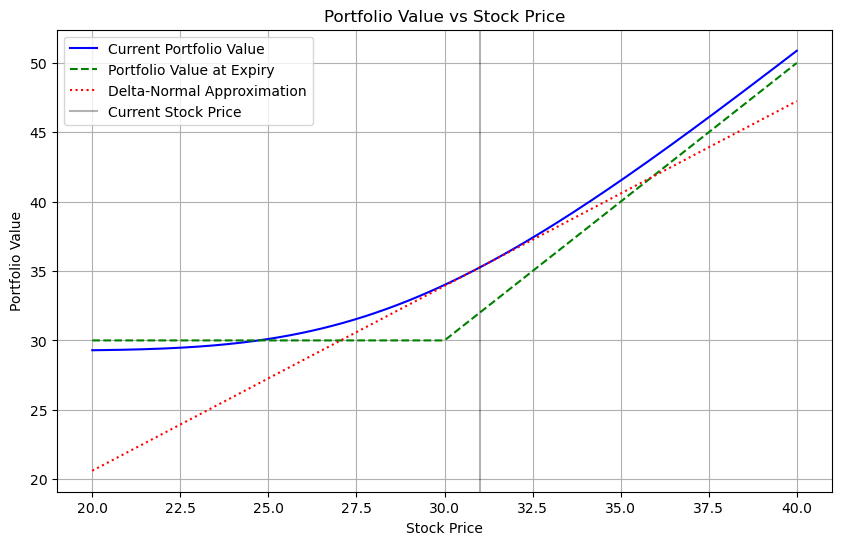


E. Differences Between the Two Methods:
   1. The Delta-Normal method assumes a linear relationship between portfolio value and underlying asset price, using the portfolio's delta to approximate this relationship.
   2. Monte Carlo simulation captures the complete nonlinear payoff structure of options and considers time decay.
   3. The Delta-Normal method works well for small price movements but is inaccurate for large movements due to gamma effects.
   4. Monte Carlo simulation is more accurate for portfolios containing options because it simulates the complete distribution of possible outcomes.
   5. When plotting portfolio value against stock price, we can see that this relationship is nonlinear, especially as we approach the expiration date.
   6. The Delta-Normal method approximates this curve with a straight line (tangent at the current price), while Monte Carlo captures the full curvature.
   7. Monte Carlo correctly accounts for time decay (theta) of options during the holdin

In [ ]:
def plot_portfolio_payoff():
   stock_prices = np.linspace(20, 40, 200)
   
   portfolio_values_at_expiry = np.array([max(0, s - K) + max(0, K - s) + s for s in stock_prices])
   
   portfolio_values_now = np.array([gbsm_call(s, K, T, r, implied_vol, b) + 
                                   gbsm_put(s, K, T, r, implied_vol, b) + s 
                                   for s in stock_prices])
   
   delta_at_s0 = call_delta + put_delta + 1
   delta_normal_values = np.array([call_market_price + put_price_gbsm + S + 
                                  delta_at_s0 * (s - S) for s in stock_prices])
   
   plt.figure(figsize=(10, 6))
   plt.plot(stock_prices, portfolio_values_now, 'b-', label='Current Portfolio Value')
   plt.plot(stock_prices, portfolio_values_at_expiry, 'g--', label='Portfolio Value at Expiry')
   plt.plot(stock_prices, delta_normal_values, 'r:', label='Delta-Normal Approximation')
   plt.axvline(x=S, color='black', linestyle='-', alpha=0.3, label='Current Stock Price')
   plt.grid(True)
   plt.legend()
   plt.xlabel('Stock Price')
   plt.ylabel('Portfolio Value')
   plt.title('Portfolio Value vs Stock Price')
   
   plt.savefig('portfolio_payoff.png')
   plt.show()

plot_portfolio_payoff()
